In [1]:
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
import os
import xarray as xr
import numpy as np
import xesmf as xe
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from collections import OrderedDict
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
%matplotlib inline

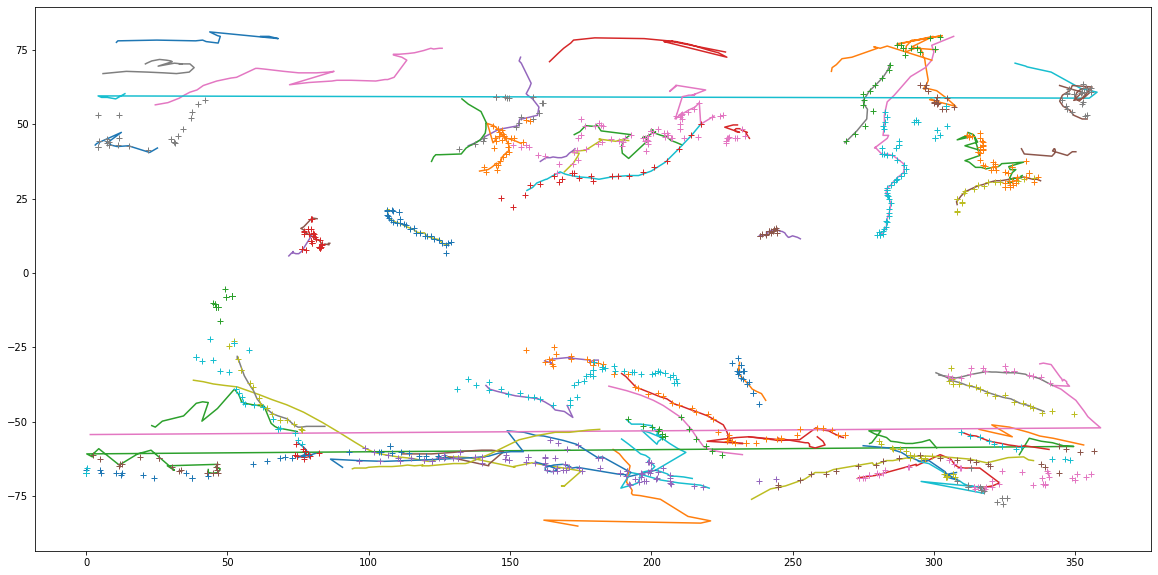

In [181]:
plt.figure(figsize=(20,10))
in_file = '/work/08589/hvtran/ls6/ERA5_PredRNN-main/validation/ERA5_TC_tracks.txt'
track_df = pd.read_csv(in_file)
track_df.columns = track_df.columns.str.strip()
groups = track_df.groupby('track_id')
for name, group in groups:
    plt.plot(group.lon, group.lat)

in_file = '/work/08589/hvtran/ls6/ERA5_PredRNN-main/validation/PredRNN_TC_tracks.txt'
track_df = pd.read_csv(in_file)
track_df.columns = track_df.columns.str.strip()
groups = track_df.groupby('track_id')
for name, group in groups:
    plt.plot(group.lon, group.lat,'+')

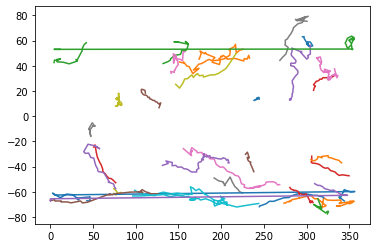

In [177]:
in_file = '/work/08589/hvtran/ls6/ERA5_PredRNN-main/validation/PredRNN_TC_tracks.txt'
track_df = pd.read_csv(in_file)
track_df.columns = track_df.columns.str.strip()
groups = track_df.groupby('track_id')
for name, group in groups:
    plt.plot(group.lon, group.lat)

In [85]:
in_dir = '/work/08589/hvtran/ls6/ERA5_PredRNN-main/predrnn-pytorch/checkpoints/2012_predrnn_test/test_result/'
out_dir = '/scratch/08589/hvtran/PredRNN_Sandy/raw/'
start_date = datetime(2012,10,21,12)
step = 12
n_lead_time = 336
list_batchs = sorted([name for name in os.listdir(in_dir) if os.path.isdir(os.path.join(in_dir, name))])
n_batchs = len(list_batchs)
out_pd_file = out_dir+'/prediction_'+start_date.strftime('%Y%m%d%H')+'_'+str(n_batchs)+\
                '_'+str(n_lead_time)+'.'+'202208121537'+'.nc'
out_gt_file = out_dir+'/truth_'+start_date.strftime('%Y%m%d%H')+'_'+str(n_batchs)+\
                '_'+str(n_lead_time)+'.'+'202208121537'+'.nc'


In [137]:
#Load data
valid_ds = xr.open_dataset(out_gt_file)
pred_ds = xr.open_dataset(out_pd_file)
#pred_ds = pred_ds.isel(lead_time=slice(0, None, 6))
print(valid_ds, pred_ds)

<xarray.Dataset>
Dimensions:    (time: 348, lat: 720, lon: 1440)
Coordinates:
  * lon        (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat        (lat) float64 90.0 89.75 89.5 89.25 ... -89.0 -89.25 -89.5 -89.75
  * time       (time) datetime64[ns] 2012-10-21T12:00:00 ... 2012-11-04T23:00:00
Data variables:
    u10        (time, lat, lon) float64 ...
    v10        (time, lat, lon) float64 ...
    t2m        (time, lat, lon) float64 ...
    sea_press  (time, lat, lon) float64 ...
    tp         (time, lat, lon) float64 ...
    tcwv       (time, lat, lon) float64 ... <xarray.Dataset>
Dimensions:    (time: 1, lead_time: 336, lat: 720, lon: 1440)
Coordinates:
  * lon        (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat        (lat) float64 90.0 89.75 89.5 89.25 ... -89.0 -89.25 -89.5 -89.75
  * lead_time  (lead_time) float64 0.0 1.0 2.0 3.0 ... 332.0 333.0 334.0 335.0
  * time       (time) datetime64[ns] 2012-10-21T12:00:00
Data variable

In [169]:
flat_pred_ds = pred_ds.isel(time=0)
temp_init_time = datetime.utcfromtimestamp(flat_pred_ds.time.values.astype(int) * 1e-9)
flat_pred_ds['lead_time'] = (temp_init_time - datetime(2001,1,1,0)).total_seconds() / 3600. + flat_pred_ds.lead_time
flat_pred_ds.lead_time.attrs['units']='hours since 2001-01-01 00:00:00'
flat_pred_ds.lead_time.attrs['calendar']='standard'
flat_pred_ds = flat_pred_ds.drop_vars('time')
flat_pred_ds = flat_pred_ds.rename({'lead_time': 'time'})
flat_pred_ds.to_netcdf(out_pd_file.replace('.nc','_1.nc'))

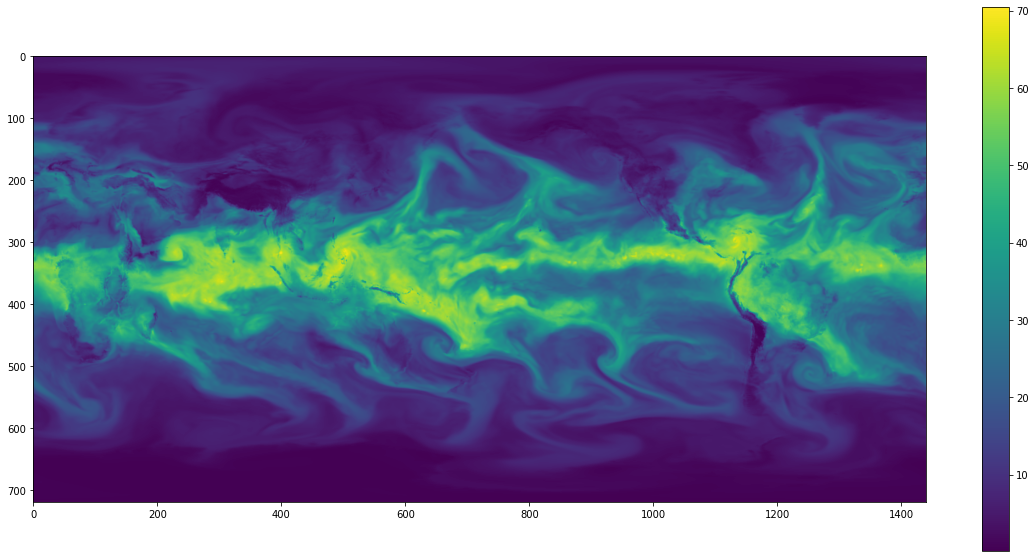

In [44]:
plt.figure(figsize=(20,10))
plt.imshow(valid_ds.tcwv[40,...])
plt.colorbar()

In [6]:
def storm_path(xd_arr, reverse=-1, search_thres = 2, intens_thres = 300):
    if len(xd_arr.shape) == 3:
        type='valid'
        n_time = xd_arr.shape[0]
        time_array = np.arange(0,n_time,6)
    else:
        type='pred'
        n_time = xd_arr.shape[1]
        time_array = np.arange(0,n_time*6,6)
    storm_df = pd.DataFrame()
    timei = 0
    if type=='valid':
        blobs_dog = blob_dog(xd_arr.isel(time=timei) *reverse, max_sigma=30, threshold=intens_thres)
        blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    else:
        blobs_dog = blob_dog(xd_arr.isel(time=0).sel(lead_time=timei)*reverse, max_sigma=30, threshold=intens_thres)
        blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    y,x,r = blobs_dog[:,0],blobs_dog[:,1],blobs_dog[:,2]
    active_list = {}
    full_list = {}
    for ii, xi in enumerate(x):
        active_list[ii+1] = [[xi,y[ii],r[ii],timei]] 
    last_item = ii + 1
    for timei in time_array[1:]:
        if type=='valid':
            blobs_dog = blob_dog(xd_arr.isel(time=timei) *reverse, max_sigma=30, threshold=intens_thres)
            blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
        else:
            blobs_dog = blob_dog(xd_arr.isel(time=0).sel(lead_time=timei)*reverse, max_sigma=30, threshold=intens_thres)
            blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
        y,x,r = blobs_dog[:,0],blobs_dog[:,1],blobs_dog[:,2]
        new_keys = list(range(x.shape[0]))
        for keyi in list(active_list.keys()):
            x_, y_,_ , _ = active_list[keyi][-1]
            delete_or_not = 1
            for ii, xi in enumerate(x):
                if ii not in new_keys:
                    continue
                temp_dist = np.sqrt((x_ - xi)**2 + (y_ - y[ii])**2)
                if temp_dist < search_thres:
                    active_list[keyi].append([xi, y[ii], r[ii], timei])
                    delete_or_not = 0
                    new_keys.remove(ii)
                    break
            if delete_or_not:
                full_list[keyi] = active_list[keyi]
                del active_list[keyi]
        if len(new_keys) > 0:
            for ii in new_keys:
                active_list[last_item + 1] = [[x[ii], y[ii], r[ii], timei]]
                last_item += 1
    storm_df = pd.DataFrame()
    storm_id = []
    storm_x = []
    storm_y = []
    storm_r = []
    storm_time = []
    for keyi in list(active_list.keys()):
        tmp_results = active_list[keyi]
        storm_id += [keyi] * len(tmp_results)
        for resi in tmp_results:
            temp_lon = resi[0]
            if temp_lon < 720:
                temp_lon = temp_lon*0.25
            else:
                temp_lon = temp_lon*0.25 - 360
            storm_x.append(temp_lon)
            storm_y.append(90 - resi[1]*0.25)
            storm_r.append(resi[2])
            storm_time.append(resi[3])
    for keyi in list(full_list.keys()):
        tmp_results = full_list[keyi]
        storm_id += [keyi] * len(tmp_results)
        for resi in tmp_results:
            temp_lon = resi[0]
            if temp_lon < 720:
                temp_lon = temp_lon*0.25
            else:
                temp_lon = temp_lon*0.25 - 360
            storm_x.append(temp_lon)
            storm_y.append(90 - resi[1]*0.25)
            storm_r.append(resi[2])
            storm_time.append(resi[3])
    storm_df['ID'] = storm_id
    storm_df['lon'] = storm_x
    storm_df['lat'] = storm_y
    storm_df['r'] = storm_r
    storm_df['time'] = storm_time
    return storm_df

In [7]:
a = storm_path(pred_ds['sea_press'], search_thres=20)
b = storm_path(valid_ds['sea_press'], search_thres=20)

In [54]:
a = a[a['ID'].map(a['ID'].value_counts()) > 5]
b = b[b['ID'].map(b['ID'].value_counts()) > 5]

In [75]:
a_ = a.copy()
b_ = b.copy()

a_.x = a_.lon/0.25 + 720
a_.y = (90 - a_.lat)/0.25 

b_.x = b_.lon/0.25 + 720
b_.y = (90 - b_.lat)/0.25


/tmp/ipykernel_1929990/3974425609.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  a_.x = a_.lon/0.25 + 720
/tmp/ipykernel_1929990/3974425609.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  a_.y = (90 - a_.lat)/0.25
/tmp/ipykernel_1929990/3974425609.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  b_.x = b_.lon/0.25 + 720
/tmp/ipykernel_1929990/3974425609.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  b_.y = (90 - b_.lat)/0.25


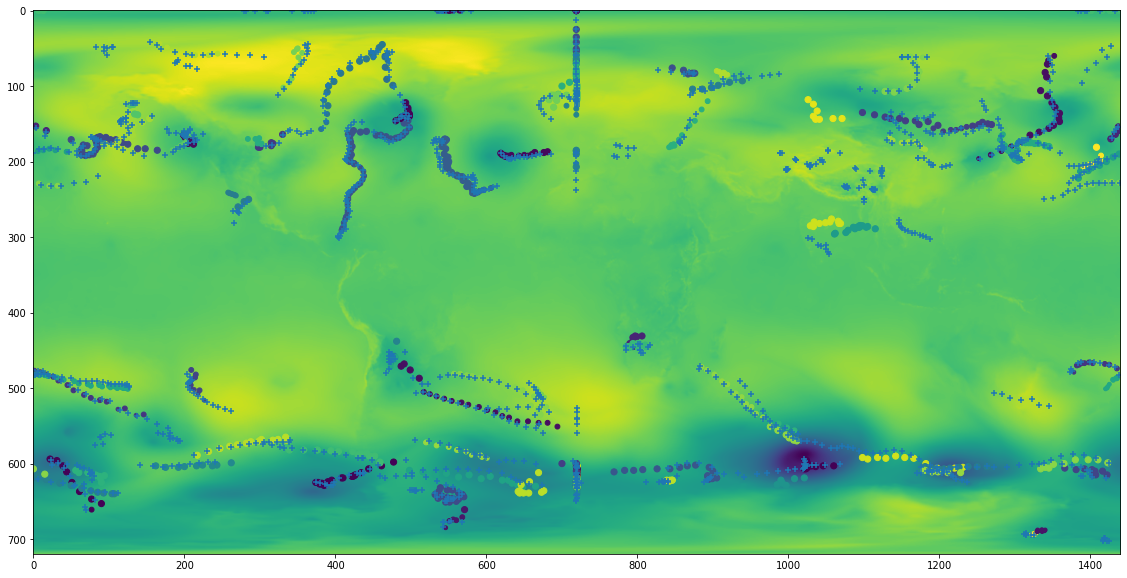

In [77]:
test = valid_ds['sea_press'].isel(time=0)
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((test[:,720:],test[:,:720])))
plt.scatter(a_.x,a_.y, c = a.ID, s = a.r, marker='o')
plt.scatter(b_.x,b_.y, marker='+')

plt.savefig('storm_track1.png',dpi=200)

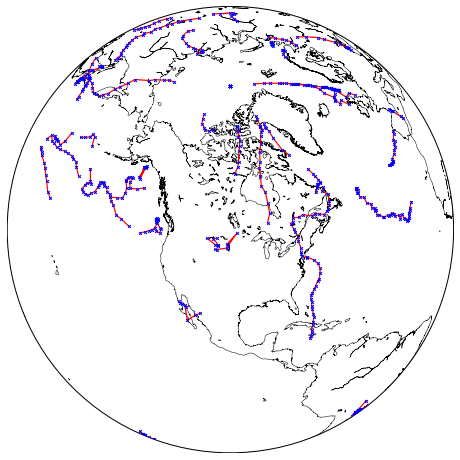

In [78]:
lonmin, lonmax = -180, 180
latmin, latmax = -90, 90

fig = plt.figure(figsize=(8,10))
axx = fig.add_subplot(111)
#m = Basemap(projection='merc', resolution="l", llcrnrlon=lonmin, llcrnrlat=latmin, urcrnrlon=lonmax, urcrnrlat=latmax)
m = Basemap(projection='ortho', resolution="l", lat_0=50, lon_0=-100)

m.drawcoastlines(color='k',linewidth=0.5,zorder=3)

groups_a = a.groupby('ID')
for name, group in groups_a:
    lons = group['lon'].values
    lats = group['lat'].values
    x,y = m(lons, lats)
    m.plot(x,y,'x',color='b', zorder=4,label = 'PredRNN',markersize=2.8)
#m.drawcountries(color='k',linewidth=0.1,zorder=3)

groups_b = b.groupby('ID')
for name, group in groups_a:
    lons = group['lon'].values
    lats = group['lat'].values
    x,y = m(lons, lats)
    m.plot(x,y,'-',color='r', zorder=3,label = 'ERA5',linewidth=1.2)

plt.savefig('storm_track2.png',dpi=200)

In [131]:
AR_mask = xr.open_dataset('/work/08589/hvtran/ls6/ERA5_PredRNN-main/validation/ERA5_AR_NFF_files.nc')
print(AR_mask)

<xarray.Dataset>
Dimensions:     (time: 58, lat: 720, lon: 1440)
Coordinates:
  * time        (time) datetime64[ns] 2012-10-21T12:00:00 ... 2012-11-04T18:0...
  * lat         (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75
  * lon         (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    binary_tag  (time, lat, lon) int8 ...


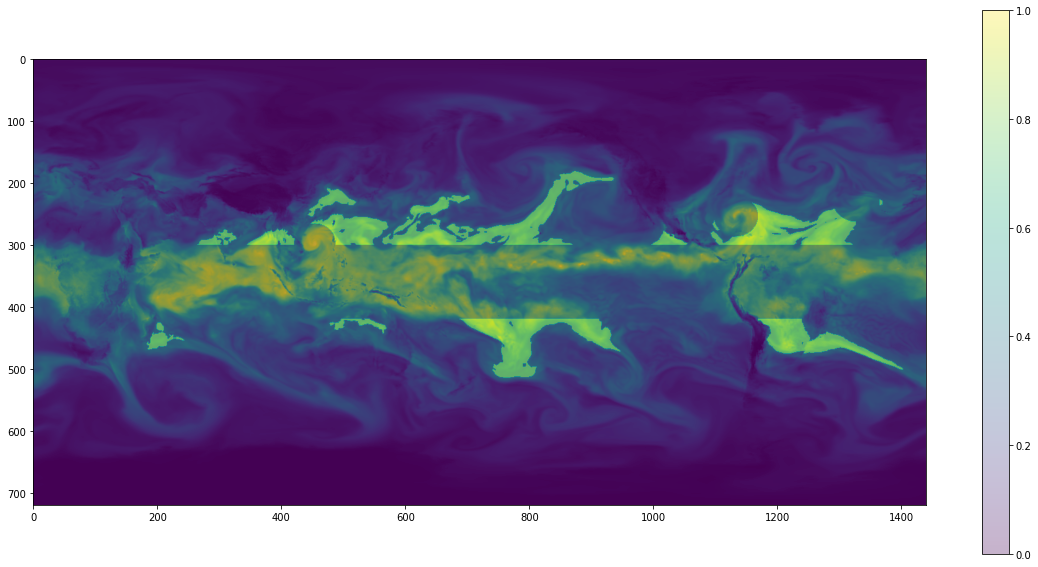

In [132]:
i = 16
plt.figure(figsize=(20,10))
plt.imshow(valid_ds.tcwv[6*i,...])
plt.imshow(AR_mask.binary_tag[i,...],alpha=0.3)
plt.colorbar()

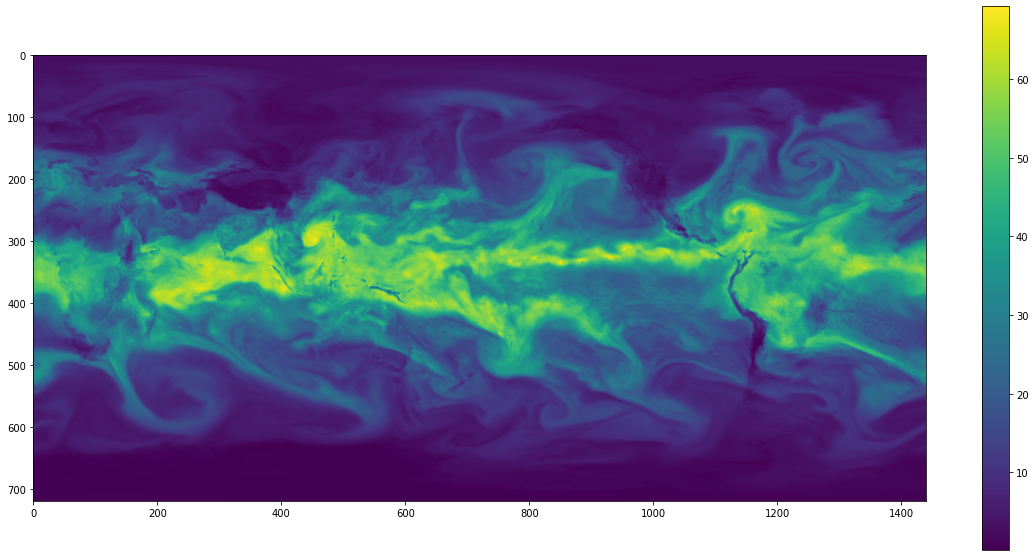

In [126]:
plt.figure(figsize=(20,10))
plt.imshow(valid_ds.tcwv[6*i,...])
plt.colorbar()

In [133]:
filter_precip = xr.open_dataset('/work/08589/hvtran/ls6/ERA5_PredRNN-main/validation/ERA5_filtered_precip_files.nc')
print(filter_precip)

<xarray.Dataset>
Dimensions:  (time: 348, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-21T12:00:00 ... 2012-11-04T23:00:00
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.0 -89.25 -89.5 -89.75
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    tp       (time, lat, lon) float64 ...


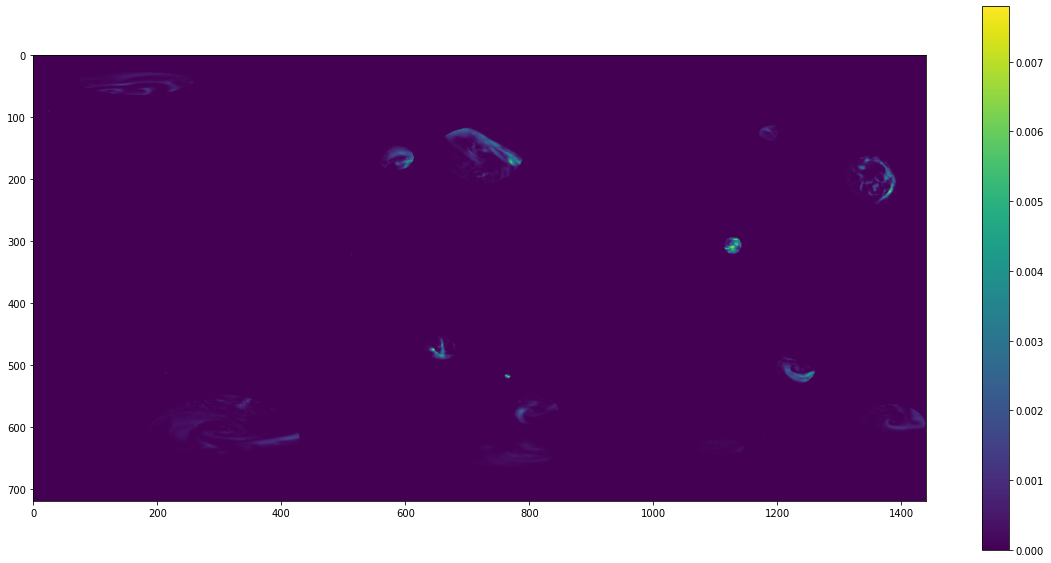

In [136]:
plt.figure(figsize=(20,10))
plt.imshow(filter_precip.tp[6*4,...])
plt.colorbar()